Usage:
- Run CountrySearches.ipynb to obtain the list of users from the past year
- Run this scrip to read in the users_NL_last_year.txt and postprocess it into a post

Todo:
- [ ] automate user_NL.txt
- [ ] create automatic post text
- [x] create some nice plots perhaps using the fish graphics
- [x] Province plot with numbers

In [1]:
# Build a list of active users suitable for a Hive post
# Loads users from file users.txt. Lines starting with R are regions

from datetime import datetime, timedelta, date, timedelta
from beem import Hive
from beem.account import Account
from beem.amount import Amount
from beem.comment import Comment
from beem.exceptions import ContentDoesNotExistsException
from beem.instance import set_shared_blockchain_instance
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sqlalchemy.engine import URL
import sqlalchemy as sa
from sqlalchemy import create_engine

In [4]:
with open('pw.txt') as f:
    for l in f:
        uname, pw = l.split()

cnxn_str = ("Driver={ODBC Driver 18 for SQL Server};"
            "Server=vip.hivesql.io;"
            "Database=DBHive;"
            f"UID={uname};"
            f"PWD={pw};TrustServerCertificate=yes;")

connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": cnxn_str})
engine = create_engine(connection_url)


In [5]:
hive = Hive(node=['https://anyx.io'])#https://rpc.ausbit.dev','https://api.deathwing.me', 'https://api.hive.blog'])
set_shared_blockchain_instance(hive)
stop = datetime.utcnow() - timedelta(days=40) # Checks last month
stopstr = stop.strftime('%Y-%m-%d')
fullstop = datetime.utcnow() - timedelta(days=365+9) # Checks last year
sqlfromdate = (date.today()-timedelta(days=365+9)).strftime('%Y-%m-%d')
sqlmonth = (date.today()-timedelta(days=31+9)).strftime('%Y-%m-%d')
#print(sqlfromdate)

today = date.today()-timedelta(days=9)
print(today)

2024-01-20


In [7]:
hacked = []
with open('steemengineteam_group.txt','r') as f:
    for l in f:
        hacked.append(l.strip())

In [8]:
def useractive(user):
    # Work back looking for last post/comment or vote
    acc = Account(user)#, blockchain_instance=hive)
    voted = commented = activeyear = False

    activeyear = False
    for a in acc.history_reverse(stop=fullstop, only_ops=["vote", 
                                                  "comment"]):
        activeyear = True
        if a['timestamp'][:10] >= stopstr:
            if a["type"] == "vote":
                voted = True
            if a["author"] == user:
                if a["type"] == "comment":
                    commented = True
                    break # Don't need to check if they voted as well
        else:
            break
    return (voted, commented, activeyear)

def useractivex(user, sql=True):
    # Work back looking for last post/comment or vote
    acc = Account(user)#, blockchain_instance=hive)
    voted = commented = activeyear = False

    with engine.begin() as conn:
        if not sql and not (voted or commented):
            activeyear = False
            for a in acc.history_reverse(stop=fullstop, only_ops=["vote", 
                                                          "comment"]):
                activeyear = True
                break

        if False:
                
            r = pd.read_sql_query(f"""select count(*) as count
                    from Accounts a
                    where a.name = '{user}'
                        and (a.last_vote_time  >= '{sqlfromdate}' or a.last_post  >= '{sqlfromdate}')
                        """, conn)
            for i, l in r.iterrows():
                activeyear = l['count'] > 0
                break

        if sql:
            r = pd.read_sql_query(f"""select a.last_vote_time, a.last_post
                    from Accounts a
                    where a.name = '{user}'
                        """, conn)
            for i, l in r.iterrows():
                #print(l['last_vote_time'], l['last_post'])
                activeyear = str(l['last_vote_time']) >= sqlfromdate or str(l['last_post']) >= sqlfromdate
                if str(l['last_post']) >= sqlmonth:
                    commented = True
                elif str(l['last_vote_time']) >= sqlmonth:
                    voted = True
                break

            
    if False and activeyear:
        for a in acc.history_reverse(stop=stop, only_ops=["vote", 
                                                          "comment"]):
            if a["type"] == "vote":
                voted = True
            if a["author"] == user:
                if a["type"] == "comment":
                    commented = True
                    break # Don't need to check if they voted as well

    return (voted, commented, activeyear)

In [9]:
def insert_introduction():

    month = date.today().strftime('%B %Y')

    print(f"The Dutch List: {month}\n\n") 
    print(f"""

# Introduction

Intro text here


# Previous Posts and Activity Logs

- [Previous Month]() - Active

""")


def insert_province_section():
    print("""# Dutch Users by Province

User text here

""")

In [10]:
def output_region(region, active, voting, inactive):
    
    
    if region != None:
        act, voter, inact = len(active), len(voting), len(inactive)
        #print(f'## {region} (Posting/Voting only: {act}/{voter})\n')
        print(f'## {region} (Active: {act}/{voter}/{inact})\n')

        if act:
            print(f'Posting ({act}): \n@'+ ('\n@'.join(sorted(active))))
            print()
        else: 
            print(f'Posting ({act}): \nNo actively posting users in this region')
            print()
        if voter:
            print(f'Voting only ({voter}):\n@'+ ('\n@'.join(sorted(voting))))
            print()
        else:
            print(f'Voting only ({voter}): \nNo actively voting users in this region')
            print()
        if inact:
            print(f'Inactive ({inact}):\n@'+ ('\n@'.join(sorted(inactive))))
            print()
        else: 
            print(f'Inactive ({inact}): \nNo inactive users in this region')
            print()      

In [13]:
with open('users_NL_last_year.txt', 'r') as f:
    active = []
    inactive = []
    voting =[]
    cmttl, vtrtl, inactl = 0,0,0
    region = None
    now = datetime.utcnow() 
    total_active = 0
    fish = {'Redfish': 0, 'Minnow':0, 'Dolphin':0, 'Orca':0, 'Whale':0}
    age = {'1 Month':0, '2 Months':0, '3 Months':0, 'Year':0, 'Older':0}
    
    ## POST START
    insert_introduction()
    insert_province_section()
    for l in f:
        fields = l.split(':')
        if fields[0] == 'R':
            output_region(region, active, voting, inactive)
            total_active += len(active) # Will not count the last region, but exclude expats from total anyway
            region = fields[1].strip()
            active, voting, inactive = [], [], []
        else:
            name = dname = fields[0].strip()
            if '(' in name:
                dname = name
                name = name[:(name.find('(')-1)]
            if not name in hacked:
                voter, commenter, activeyear = useractivex(name)
                if commenter:
                    active.append(dname)
                    cmttl +=1
                elif voter:
                    voting.append(dname)
                    vtrtl +=1
                elif activeyear: # Inactive
                    inactive.append(dname)
                    inactl +=1
                if commenter or voter:
                    acc = Account(name)
                    hp = acc.balances['available'][2].amount_decimal
                    if hp > 1E9:
                        fish['Whale'] += 1
                    elif hp > 1E8:
                        fish['Orca'] += 1
                    elif hp > 1E7:
                        fish['Dolphin'] += 1
                    elif hp > 1E6:
                        fish['Minnow'] += 1
                    else:
                        fish['Redfish'] += 1

                    for i in acc.get_account_history(0,1):
                        created = cr = datetime.strptime(i['timestamp'], '%Y-%m-%dT%H:%M:%S')
                    accage = (now - created).days
                    if accage > 365:
                        age['Older'] += 1
                    elif accage > 90:
                        
                        age['Year'] += 1
                    elif accage > 60:
                        print(name)
                        age['3 Months'] += 1
                    elif accage > 30:
                        age['2 Months'] += 1
                    else:
                        age['1 Month'] += 1

    output_region(region, active, voting, inactive)
    print('## Totals\n')
    print(f'**Total active** Commenting: {cmttl}, Voting Only: {vtrtl}, Inactive the past year: {inactl}\n')

    minnowhp = hive.vests_to_hp(1E6)
    print('# Charts\n')
    print(f"This shows the numbers in each category of the active and voting accounts. Level is based on 'VESTS' with Minnow equating to a million VESTS.\n")
    print('|Level|Number|Threshold|')
    print('|-|-|-|')
    for i,f in enumerate(fish):
        hp = f'{minnowhp:11.2f} HP' if i > 0 else ''
        print(f'|{f:8}|{fish[f]:4}|{hp}|')
        if i > 0:
            minnowhp *= 10
    print('\n This shows when people joined Hive. The last few months are shown separately to make any changes obvious.\n')
    print('|Age|Number|')
    print('|-|-|')
    for a in age:
        print(f'|{a}|{age[a]}|')
    
    print('''
# NL Witnesses
Local witness text
''')


The Dutch List: January 2024




# Introduction

Intro text here


# Previous Posts and Activity Logs

- [Previous Month]() - Active


# Dutch Users by Province

User text here


## Noord Holland (Active: 0/0/0)

Posting (0): 
No actively posting users in this region

Voting only (0): 
No actively voting users in this region

Inactive (0): 
No inactive users in this region

## Zuid Holland (Active: 0/0/0)

Posting (0): 
No actively posting users in this region

Voting only (0): 
No actively voting users in this region

Inactive (0): 
No inactive users in this region

## Overijssel (Active: 0/0/0)

Posting (0): 
No actively posting users in this region

Voting only (0): 
No actively voting users in this region

Inactive (0): 
No inactive users in this region

## Noord Brabant (Active: 0/0/0)

Posting (0): 
No actively posting users in this region

Voting only (0): 
No actively voting users in this region

Inactive (0): 
No inactive users in this region

## Utrecht (Active: 0/0/0)

Posti

{'Redfish': 0, 'Minnow': 0, 'Dolphin': 0, 'Orca': 0, 'Whale': 0}


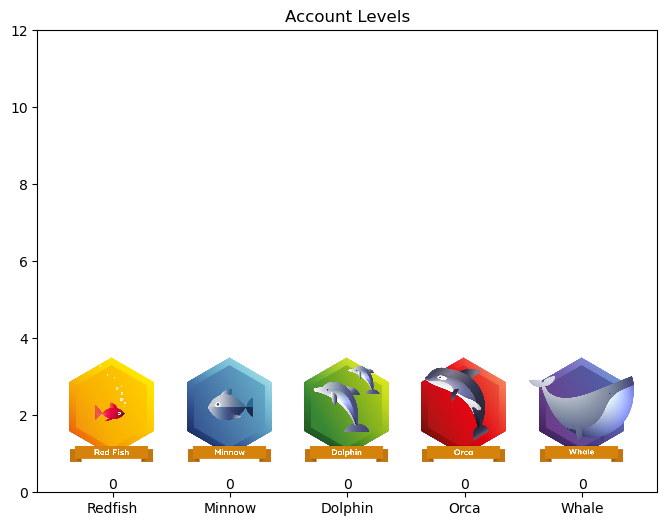

In [14]:
print(fish)
x_pos = range(len(fish))

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
color = ['#fab904','#73b8d4','#5d9b2a',
         '#d71b1c','#8c9be6']
plt.bar(x_pos, fish.values(), color=color)
plt.xticks(x_pos, fish.keys(), rotation=0)
plt.title('Account Levels')
ax.set_ylim(0,max(fish.values())+12)

shiftX = 0.52  
shiftY = 0.52  
arr_img = plt.imread("level1.png")
im = OffsetImage(arr_img, zoom=.15)
ab1 = AnnotationBbox(im, (x_pos[0]+shiftX,fish['Redfish']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level2.png")
im = OffsetImage(arr_img, zoom=.15)
ab2 = AnnotationBbox(im, (x_pos[1]+shiftX,fish['Minnow']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level3.png")
im = OffsetImage(arr_img, zoom=.15)
ab3 = AnnotationBbox(im, (x_pos[2]+shiftX,fish['Dolphin']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level4.png")
im = OffsetImage(arr_img, zoom=.15)
ab4 = AnnotationBbox(im, (x_pos[3]+shiftX,fish['Orca']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

arr_img = plt.imread("level5.png")
im = OffsetImage(arr_img, zoom=.15)
ab5 = AnnotationBbox(im, (x_pos[4]+shiftX,fish['Whale']+shiftY), box_alignment=(1.1,-0.1),frameon=False)

ax.add_artist(ab1)
ax.add_artist(ab2)
ax.add_artist(ab3)
ax.add_artist(ab4)
ax.add_artist(ab5)


plt.text(x_pos[0],fish['Redfish'],s=fish.get('Redfish'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[1],fish['Minnow'],s=fish.get('Minnow'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[2],fish['Dolphin'],s=fish.get('Dolphin'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[3],fish['Orca'],s=fish.get('Orca'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[4],fish['Whale'],s=fish.get('Whale'),horizontalalignment='center',verticalalignment='bottom')

plt.savefig('fish.png')

{'1 Month': 0, '2 Months': 0, '3 Months': 0, 'Year': 0, 'Older': 0}


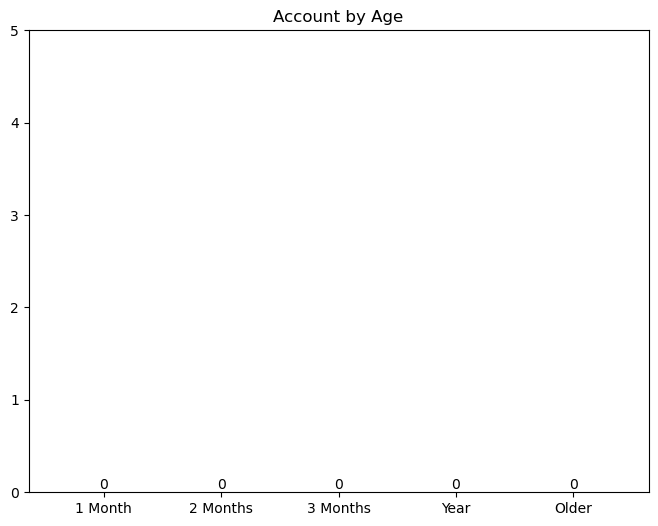

In [15]:
print(age)
x_pos = range(len(age))
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
color=['#fab904','#73b8d4','#5d9b2a','#d71b1c','#8c9be6']
plt.bar(x_pos, age.values(), color=color)
plt.xticks(x_pos, age.keys(), rotation=0)
plt.title('Account by Age')
ax.set_ylim(0,max(age.values())+5)

plt.text(x_pos[0],age['1 Month'],s=age.get('1 Month'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[1],age['2 Months'],s=age.get('2 Months'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[2],age['3 Months'],s=age.get('3 Months'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[3],age['Year'],s=age.get('Year'),horizontalalignment='center',verticalalignment='bottom')
plt.text(x_pos[4],age['Older'],s=age.get('Older'),horizontalalignment='center',verticalalignment='bottom')

plt.savefig('age.png')


In [16]:
def printFishAndAge():
    minnowhp = hive.vests_to_hp(1E6)
    print('|Level|Number|Stake|')
    print('|-|-|-|')
    for i,f in enumerate(fish):
        hp = f'{minnowhp:11.2f} HP' if i > 0 else ''
        print(f'|{f:8}|{fish[f]:4}|{hp}|')
        if i > 0:
            minnowhp *= 10
    print('\n')
    print('|Age|Number|')
    print('|-|-|')
    for a in age:
        print(f'|{a}|{age[a]}|')
